In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from package import function
import shap

In [2]:
Xtrain = pd.read_csv("Xtrain.csv")
ytrain = pd.read_csv("ytrain.csv").cardio
Xtest = pd.read_csv("Xtest.csv")
ytest = pd.read_csv("ytest.csv").cardio

The score is 0.734048 for XGB baseline


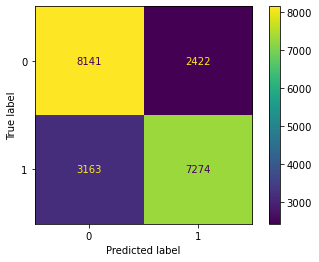

In [3]:
model_baseline = XGBClassifier(n_estimators = 100,use_label_encoder=False,eval_metric='mlogloss',random_state=0)
model_baseline.fit(Xtrain,ytrain)
ypr = model_baseline.predict(Xtest)
probTest = model_baseline.predict_proba(Xtest)
probTest = probTest[:,1]
function.eval_confusion("XGB baseline",model_baseline.score(Xtest,ytest),ypr,ytest)

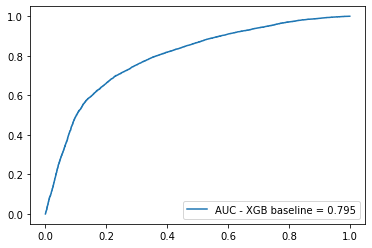

In [4]:
function.eval_auc("XGB baseline",ytest,probTest)

In [5]:
params={
 "verbosity"        : [0, 1, 2, 3],
 "n_estimators"     : [150, 160, 175, 185, 195, 200],
 "learning_rate"    : [0.01,0.02, 0.03, 0.04] ,
 "max_depth"        : [ 5, 6, 7, 8, 9],
 "min_child_weight" : [ 5, 7, 9, 11],
 "gamma"            : [ 0.05, 0.075, 0.1, 0.15],
 "colsample_bytree" : [ 0.65, 0.68, 0.7, 0,75],
 "colsample_bylevel": [0.63, 0.65, 0.7, 0,75, 0.8, 0.9],
 "colsample_bynode" : [0.63, 0.65, 0.7, 0,75, 0.8, 0.9],
 "subsample"        : [0.4, 0.45, 0.5, 0.55, 0.6]
}

In [6]:
classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(model_baseline,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits



15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hanyunguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hanyunguo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/Users/hanyunguo/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1400, in fit
    self._Booster = train(
  File "/Users/hanyunguo/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=0,
                                           gpu_id=-1, grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bi...
                                                              0, 75, 0.8, 0.9],
                                        'colsample_bynode'

In [7]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.65,
              colsample_bytree=0.65, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.1,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=160, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)


In [8]:
print(random_search.best_params_)

{'verbosity': 0, 'subsample': 0.4, 'n_estimators': 160, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.04, 'gamma': 0.1, 'colsample_bytree': 0.65, 'colsample_bynode': 0.65, 'colsample_bylevel': 0.8}


In [9]:
model_final = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',verbosity=3, subsample=0.55, n_estimators=185, min_child_weight=9, max_depth=7, learning_rate=0.03, gamma=0.075, colsample_bytree=0.68, colsample_bynode=0.7, colsample_bylevel=0.8)
model_final.fit(Xtrain,ytrain)
y_pred = model_final.predict(Xtest)
y_train_pred = model_final.predict(Xtrain)
print('Train Accuracy', accuracy_score(ytrain, y_train_pred))
print('Test Accuracy', accuracy_score(ytest, y_pred))

[04:42:47] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[04:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=7
[04:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[04:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=7
[04:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 2 pruned nodes, max_depth=7
[04:42:47] INFO: /Users/runner/work

[04:42:51] ======== Monitor (0): Learner ========
[04:42:51] Configure: 0.000363s, 1 calls @ 363us

[04:42:51] ======== Monitor (0): GBTree ========
[04:42:51] ======== Monitor (0): TreePruner ========
[04:42:51] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[04:42:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=7
[04:42:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=7
[04:42:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 6 pruned nodes, max_depth=7
[04:42:51] INFO: /Users/runner/work/

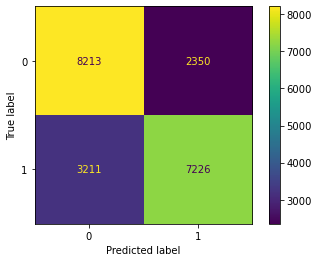

In [10]:
model_final = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',verbosity=3, subsample=0.55, n_estimators=185, min_child_weight=9, max_depth=7, learning_rate=0.03, gamma=0.075, colsample_bytree=0.68, colsample_bynode=0.7, colsample_bylevel=0.8)
model_final.fit(Xtrain,ytrain)
ypr = model_final.predict(Xtest)
probTest = model_final.predict_proba(Xtest)
probTest = probTest[:,1]
function.eval_confusion("XGB final",model_final.score(Xtest,ytest),ypr,ytest)

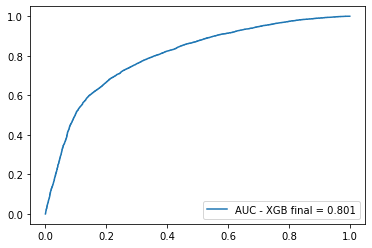

In [11]:
function.eval_auc("XGB final",ytest,probTest)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


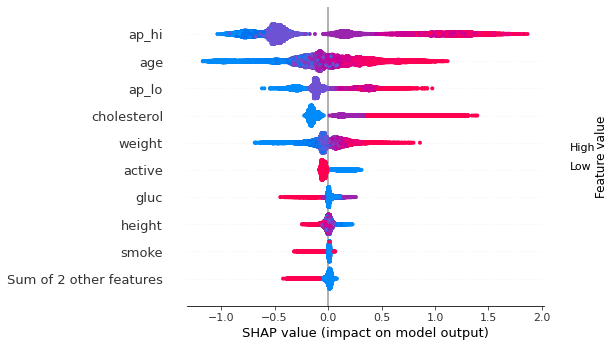

In [12]:
explainer = shap.Explainer(model_final)
shap_values = explainer(Xtest)
shap.plots.beeswarm(shap_values)